<a href="https://colab.research.google.com/github/AilingLiu/MNIST-digit-handwrite-clasification/blob/master/hand_writing_digit_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This project is following the tutorial from O'Reilly **Hands-on Machine Learning with Scikit-Learn, Keras & TensorFlow** chapter three. I am also trying to write my own codes which are not written in the book. But it should be available on his github. So you can check his github directly.

In this project, we will build an end-to-end classification model on MNIST hand-writing digit datasets.

# Set up

In [0]:
import sys
import sklearn
assert(sys.version_info >= (3, 5)) # python 3.5+
assert(sklearn.__version__ >= '0.20')

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rc('axes', labelsize=12)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import os
PROJECT_ROOT_DIR = '.'
CHAPTER_ID = 'MNIST'
PROJECT_DIR = os.path.join(PROJECT_ROOT_DIR, CHAPTER_ID)
if not os.path.isdir(PROJECT_DIR):
  os.makedirs(PROJECT_DIR)

# where to save images
IMAGE_DIR = os.path.join(PROJECT_DIR, 'IMAGES')
if not os.path.isdir(IMAGE_DIR):
  os.makedirs(IMAGE_DIR)

def save_fig(name, folder=IMAGE_DIR, format='png', tight_layout=True, dpi=300):
  path=os.path.join(folder, name + '.' + format)
  if not os.path.isdir(folder):
    os.makedirs(folder)
  if tight_layout:
    plt.tight_layout()
  plt.savefig(path, dpi=dpi, format=format)

# Get Data

In [11]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

In [12]:
X, y = mnist['data'], mnist['target']
X.shape

(70000, 784)

This dataset has 70,000 images, each image has 784 features. That is because each image is 28 x 28 pixels. Each feature contains a pixel's value, from 0(white) to 255(black). 

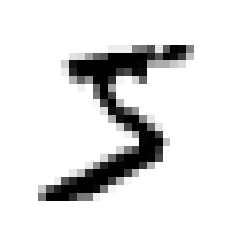

In [14]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()
#fig, axes = plt.subplots(5, 5, figsize=(25, 25))


In [0]:
#looks like a five
y[0]

'5'

In [0]:
import numpy as np
# change the data type of label from string to number since most of the ml algorithms expect numbers
y = y.astype(np.uint8)

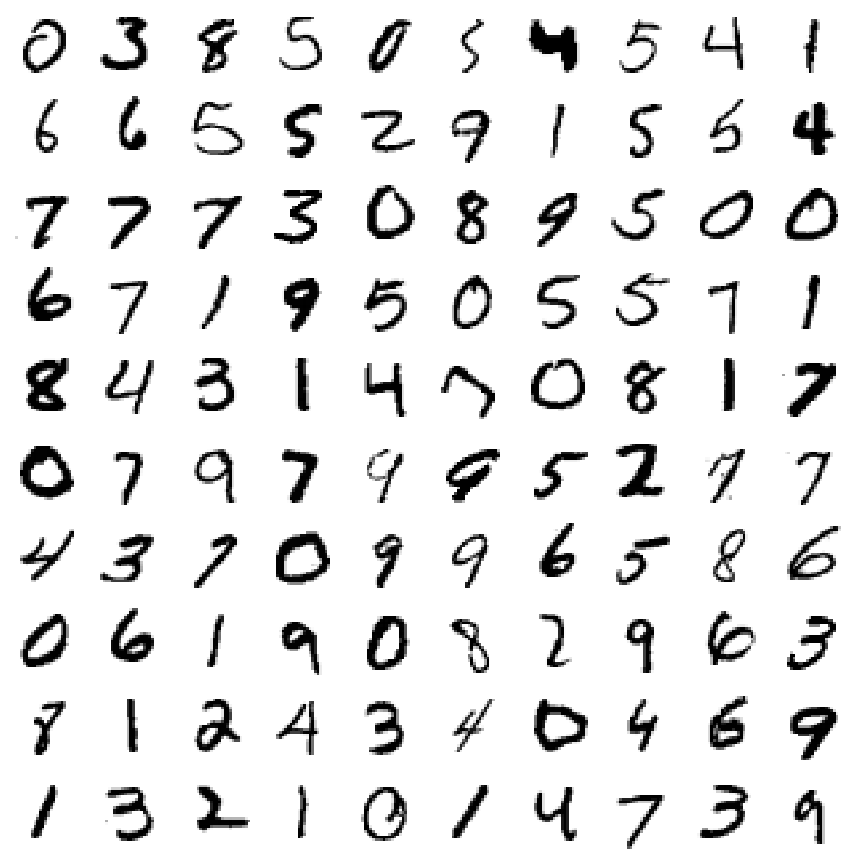

In [18]:
import random
random_image_index = random.sample(range(70000), 100)

fig = plt.figure(figsize=(12, 12))

for i in range(100):
  image = X[random_image_index[i]].reshape(28, 28)
  ax = fig.add_subplot(10, 10, i+1)
  ax.imshow(image, cmap='binary')
  ax.axis('off')

save_fig('minist_100_random_sample_images')

Above shows 100 examples from our dataset. I personally think some of them are not easy to identify as human, for example, the sixth image in the first row looks like 4, 9, or even 7. Let's see how our model is gonna perform, hopefull better than human. We will need to split the dataset into train and test set. Fortunately, MNIST dataset makes it easy for us by already spliting the first 60,000 as train, and the remaining 10000 as test. And the train set has already shuffled! Sweet.

In [0]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Train a binary classifier for number 5

In [0]:
y_train_five = (y_train == 5)
y_test_five = (y_test == 5)

In [21]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_five)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [25]:
sgd_clf.predict([X_train[np.argmax(y_train_five)]])

array([ True])

It works.

# Performance measures

## Measuring Acuracy Using Cross-Validation

In [26]:
# implement cross-validation

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

sgd_clf = SGDClassifier(random_state=42)

skfolds = StratifiedKFold(n_splits=3, random_state=42)
for train_index, test_index in skfolds.split(X_train, y_train_five):
  clone_clf = clone(sgd_clf)
  X_train_folds = X_train[train_index]
  y_train_folds = y_train_five[train_index]
  X_test_folds = X_train[test_index]
  y_test_folds = y_train_five[test_index]

  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred = clone_clf.predict(X_test_folds)
  accuracy = sum(y_test_folds == y_pred)/len(y_test_folds)
  print(accuracy)



0.95035
0.96035
0.9604


In [0]:
# we can use sklearn to do the above
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train, scoring='accuracy', cv=3)

array([0.87082583, 0.87089354, 0.88628294])

The accuracy looks good. But that's not real. We can make a dump classifier that never predict 5, i.e. makes all the prediction as false.

In [0]:
from sklearn.base import BaseEstimator

class NeverFiveClassifier(BaseEstimator):
  def fit(self, X, y=None):
    return self
  def predict(self, X):
    return np.zeros((len(X), 1), dtype=bool)

In [0]:
never_five_clf = NeverFiveClassifier()
cross_val_score(never_five_clf, X_train, y_train_five, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

It's actually better than before. The reason for that is there is only 10% of dataset that contains 5. Such imbalanced dataset, using accuracy is bad idea.

## confusion matrix

In [0]:
# use cross_val_predict so instead of getting scores, you get the predictions from each test fold

from sklearn.model_selection import cross_val_predict

y_train_predict = cross_val_predict(sgd_clf, X_train, y_train_five, cv=3)

In [0]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_five, y_train_predict)

array([[53892,   687],
       [ 1891,  3530]])

## precision and recall

In [0]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_five, y_train_predict)

0.8370879772350012

In [0]:
recall_score(y_train_five, y_train_predict)

0.6511713705958311

Now we can see the recall is much less than the precision score, and the accuracy score earlier. We can use F1 score which is the harmonic mean of precision and recall, and it gives much more weight to the low score.

In [0]:
from sklearn.metrics import f1_score

f1_score(y_train_five, y_train_predict)

0.7325171197343846

## precision and recall tradeoff

In [0]:
# we can use decision_function which can return the scores from which our classifier made the prediction, so that we can try to find the threshold to make better prediction.
from sklearn.model_selection import cross_val_predict
y_scores = cross_val_predict(sgd_clf, X_train, y_train_five, cv=3, method='decision_function')

In [0]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_train_five, y_scores)

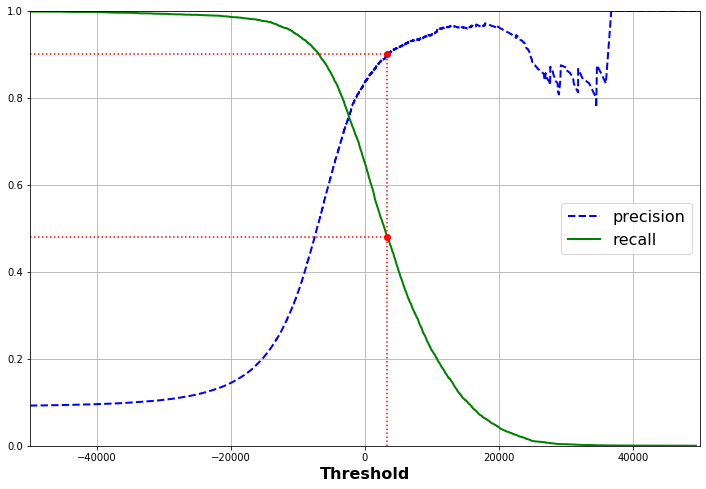

In [0]:

def plot_precision_recall_curve(precisions, recalls, thresholds):
  plt.figure(figsize=(12, 8))
  plt.plot(thresholds, precisions[:-1], 'b--', label='precision', linewidth=2)
  plt.plot(thresholds, recalls[:-1], 'g-', label='recall', linewidth=2)
  plt.xlabel('Threshold', fontweight='bold', fontsize=16)
  plt.grid(True)
  plt.legend(loc='center right', fontsize=16)
  plt.axis([-50000, 50000, 0, 1])

plot_precision_recall_curve(precision, recall, thresholds)
plt.plot(3370, 0.9, 'ro')
plt.plot(3370, 0.4798, 'ro')
plt.plot([3370, 3370], [0, 0.9], "r:")
plt.plot([-50000, 3370], [0.4798, 0.4798], 'r:')
plt.plot([-50000, 3370], [0.9, 0.9], 'r:')

Precision may be bumpier when the threshold increases. Here if we want to prioritize precison at 0.9, our recall will be about 0.4798. 

In [0]:
np.argmax(precision>0.9)

57075

In [0]:
threshold_at_90_precision = thresholds[np.argmax(precision>0.9)]
y_train_pred_90 = (y_scores > threshold_at_90_precision)
precision_score(y_train_five, y_train_pred_90)

0.9

In [0]:
recall_score(y_train_five, y_train_pred_90)

0.47980077476480354

# roc curve

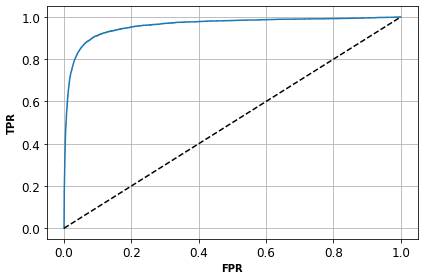

In [34]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_five, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, label=label)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlabel('FPR', fontweight='bold', fontsize=10)
  plt.ylabel('TPR', fontweight='bold', fontsize=10)
  plt.label(loc='lower right', fontsize=12)
  plt.grid(True)

plot_roc_curve(fpr, tpr)
save_fig('roc_curve_with_sgd_clf')

In [35]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_five, y_scores)

0.9604938554008616

In [36]:
# lets compare with Random Forest classifier
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier()

y_proba_forest = cross_val_predict(forest_clf, X_train, y_train_five, cv=3, method='predict_proba')

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


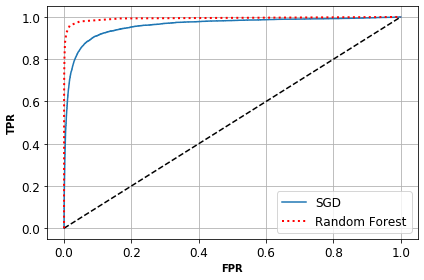

In [45]:
fpr_fr, tpr_fr, thresholds_fr = roc_curve(y_train_five, y_proba_forest[:, 1])

plot_roc_curve(fpr, tpr, label='SGD')
plt.plot(fpr_fr, tpr_fr, 'r:', linewidth=2, label='Random Forest')
plt.legend(loc='lower right', fontsize=12)
save_fig('roc_sgd_randfr')

In [47]:
roc_auc_score(y_train_five, y_proba_forest[:, 1])

0.9928504266254536

Apparently, Random Forest has achieved better performance than SGD classifier.

# Multiclassification

In [0]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict(X_train[234])

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [0]:
y_train[234]

In [0]:
svm_clf.deciion_function(X_train[234])